### Duel output UNet on pennate diatoms - first attempt
### Rayna Hamilton
### March 21, 2025

We will train a UNet neural network to detect the locations of pennate diatom cells in strained microscopy images.  This cell segmentation approach was first introduced by [Ronnenberger et al., 2015](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28).  My initial testing with this code suggested that nearby cells are often merged together by this segmentation approach, so I am taking from inspiration from the [Duel-Output Unet approach](https://github.com/ToyahJade/DO-U-Net), which addressed the issue of close-together objects by training a network to detect both objects and outlines, then subtracting the outline prediction from the object body prediction.  For this application, I am just going to train two networks, one on cell body annotations, and one on cell outlines.  The ultimate goal of this project is to predict the parasite infection status of each individual cell, but to do this we first need to determine the locations of boundaries of individual cells in the images.

In [1]:
# U-NET CNN Approach to Automated Image Analysis
    # base code from: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
#-------------------------------------------------------------------------------------------------------------

# Read in libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# %matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
# warnings.filterwarnings('ignore')

IMG_TILE_SIZE=400
IMG_CHANNELS = 3 # RGB


In [2]:
# Read in data
mother_directory = "../../data/train_images/" 
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"


if not os.path.isdir(child_directory_csv):
    os.mkdir(child_directory_csv)
if not os.path.isdir(child_directory_image):
    os.mkdir(child_directory_image)

#-------------------------------------------------------------------------------------------------------------

# get a list of files in each folder
mask_dir = "../../data/binary_masks/train/"
outline_mask_dir = "../../data/outlines/train/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]
outline_mask_list = os.listdir(outline_mask_dir)
outline_mask_list=[val for val in outline_mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images

,image_id
0,AS_A_I_15_4-20240720-C28.jpg
1,AS_A_I_22_4-20240718-C15.jpg
2,AS_A_I_22_5-20240718-C13.jpg
3,AS_B_I_15_4-20240724-C29.jpg
4,AS_B_I_22_5-20240720-C36.jpg
5,AS_B_I_22_6-20240717-C10.jpg
6,AS_B_U_15_1-20240726-C30.jpg
7,AS_C_I_15_2-20240726-C21.jpg
8,AS_C_I_15_3-20240724-C32.jpg
9,AS_C_U_15_3-20240717-C21.jpg


The training data labels are termed binary masks, meaning that all pixels in the image are either 1 (cell) or 0 (non-cell).  Currently, I have more cell body annotations than cell outline annotations, but hopefully we will have more annotations of both for subsequent runs.

In [3]:
# ================================================
# Add a column indicating if an image has a mask for outline and cell contents
# ================================================

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)
somelist=outline_mask_list
df_images['has_outline_mask'] = df_images['image_id'].apply(check_for_mask)
df_images

,image_id,has_mask,has_outline_mask
0,AS_A_I_15_4-20240720-C28.jpg,yes,no
1,AS_A_I_22_4-20240718-C15.jpg,yes,no
2,AS_A_I_22_5-20240718-C13.jpg,yes,no
3,AS_B_I_15_4-20240724-C29.jpg,yes,no
4,AS_B_I_22_5-20240720-C36.jpg,yes,no
5,AS_B_I_22_6-20240717-C10.jpg,yes,no
6,AS_B_U_15_1-20240726-C30.jpg,yes,no
7,AS_C_I_15_2-20240726-C21.jpg,yes,no
8,AS_C_I_15_3-20240724-C32.jpg,yes,no
9,AS_C_U_15_3-20240717-C21.jpg,yes,no


In [4]:

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_64152\3158210854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(24, 4)

In [5]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(24, 1040, 1388, 3)

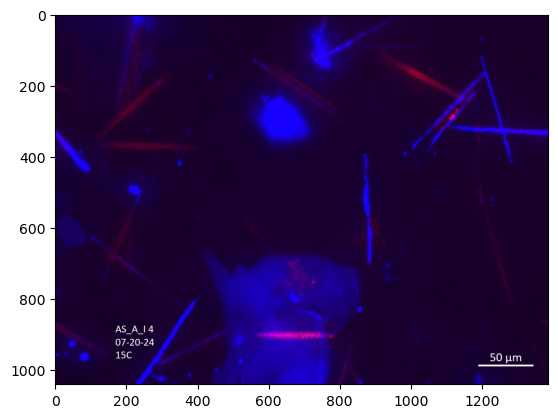

In [6]:
plt.imshow(X[0])

In the above sample image, blue lines are late-stage infected cells, and red lines are healthy cells.

In [7]:
y_cell,y_outline=[],[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask)[:,:,0]
    y_cell.append(mask)
    if mask_id in outline_mask_list:
        path_mask =outline_mask_dir + mask_id
        mask = imread(path_mask)
        y_outline.append(mask)
y_cell,y_outline=np.array(y_cell),np.array(y_outline)
y_cell.shape

(24, 1040, 1388)

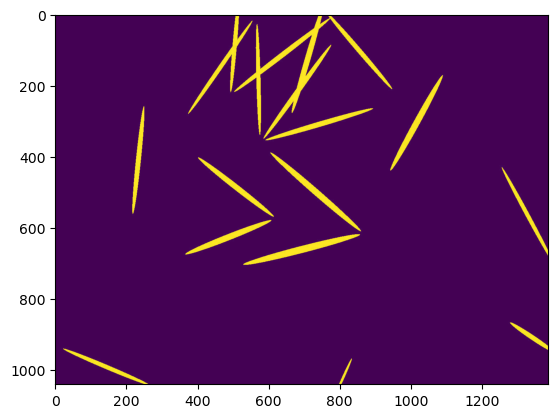

In [8]:
plt.imshow(y_cell[14])

Above are examples of the cell binary mask and outline annotation that will be used for training the networks.  Below I am splitting up the images into 400-by-400 pixel chunks, with some overlap between windows to augment our training data.  This is necessary as the network architecture requires square images and is quite picky about dimensions, but I have found that resizing the images results in an undesirable amount of distortion, particularly for the outlines.

In [9]:
X.shape

(24, 1040, 1388, 3)

In [10]:
#figure out how to join results for slices of images into a single image.   allow for overlap in edge slices

In [11]:
tiled_x_cell=[]

max_x,max_y=1040,1388
for i in range(len(X)):
    tiled_x_cell.append([])
    for y_pos in [0,400,800,1200]:
        for x_pos in [0,400,800]:
            image_slice=np.zeros((400,400,3), dtype=np.uint8)
            x_range=min(400,max_x-x_pos)
            y_range=min(400,max_y-y_pos)
            if x_range==400:
                if y_range==400:
                    image_slice=X[i,x_pos:x_pos+400,y_pos:y_pos+400]
                else:
                    image_slice=X[i,x_pos:x_pos+400,max_y-400:max_y]
            else:
                if y_range==400:
                    image_slice=X[i,max_x-400:max_x,y_pos:y_pos+400]
                else:
                    image_slice=X[i,max_x-400:max_x,max_y-400:max_y]
            tiled_x_cell[-1].append(image_slice)

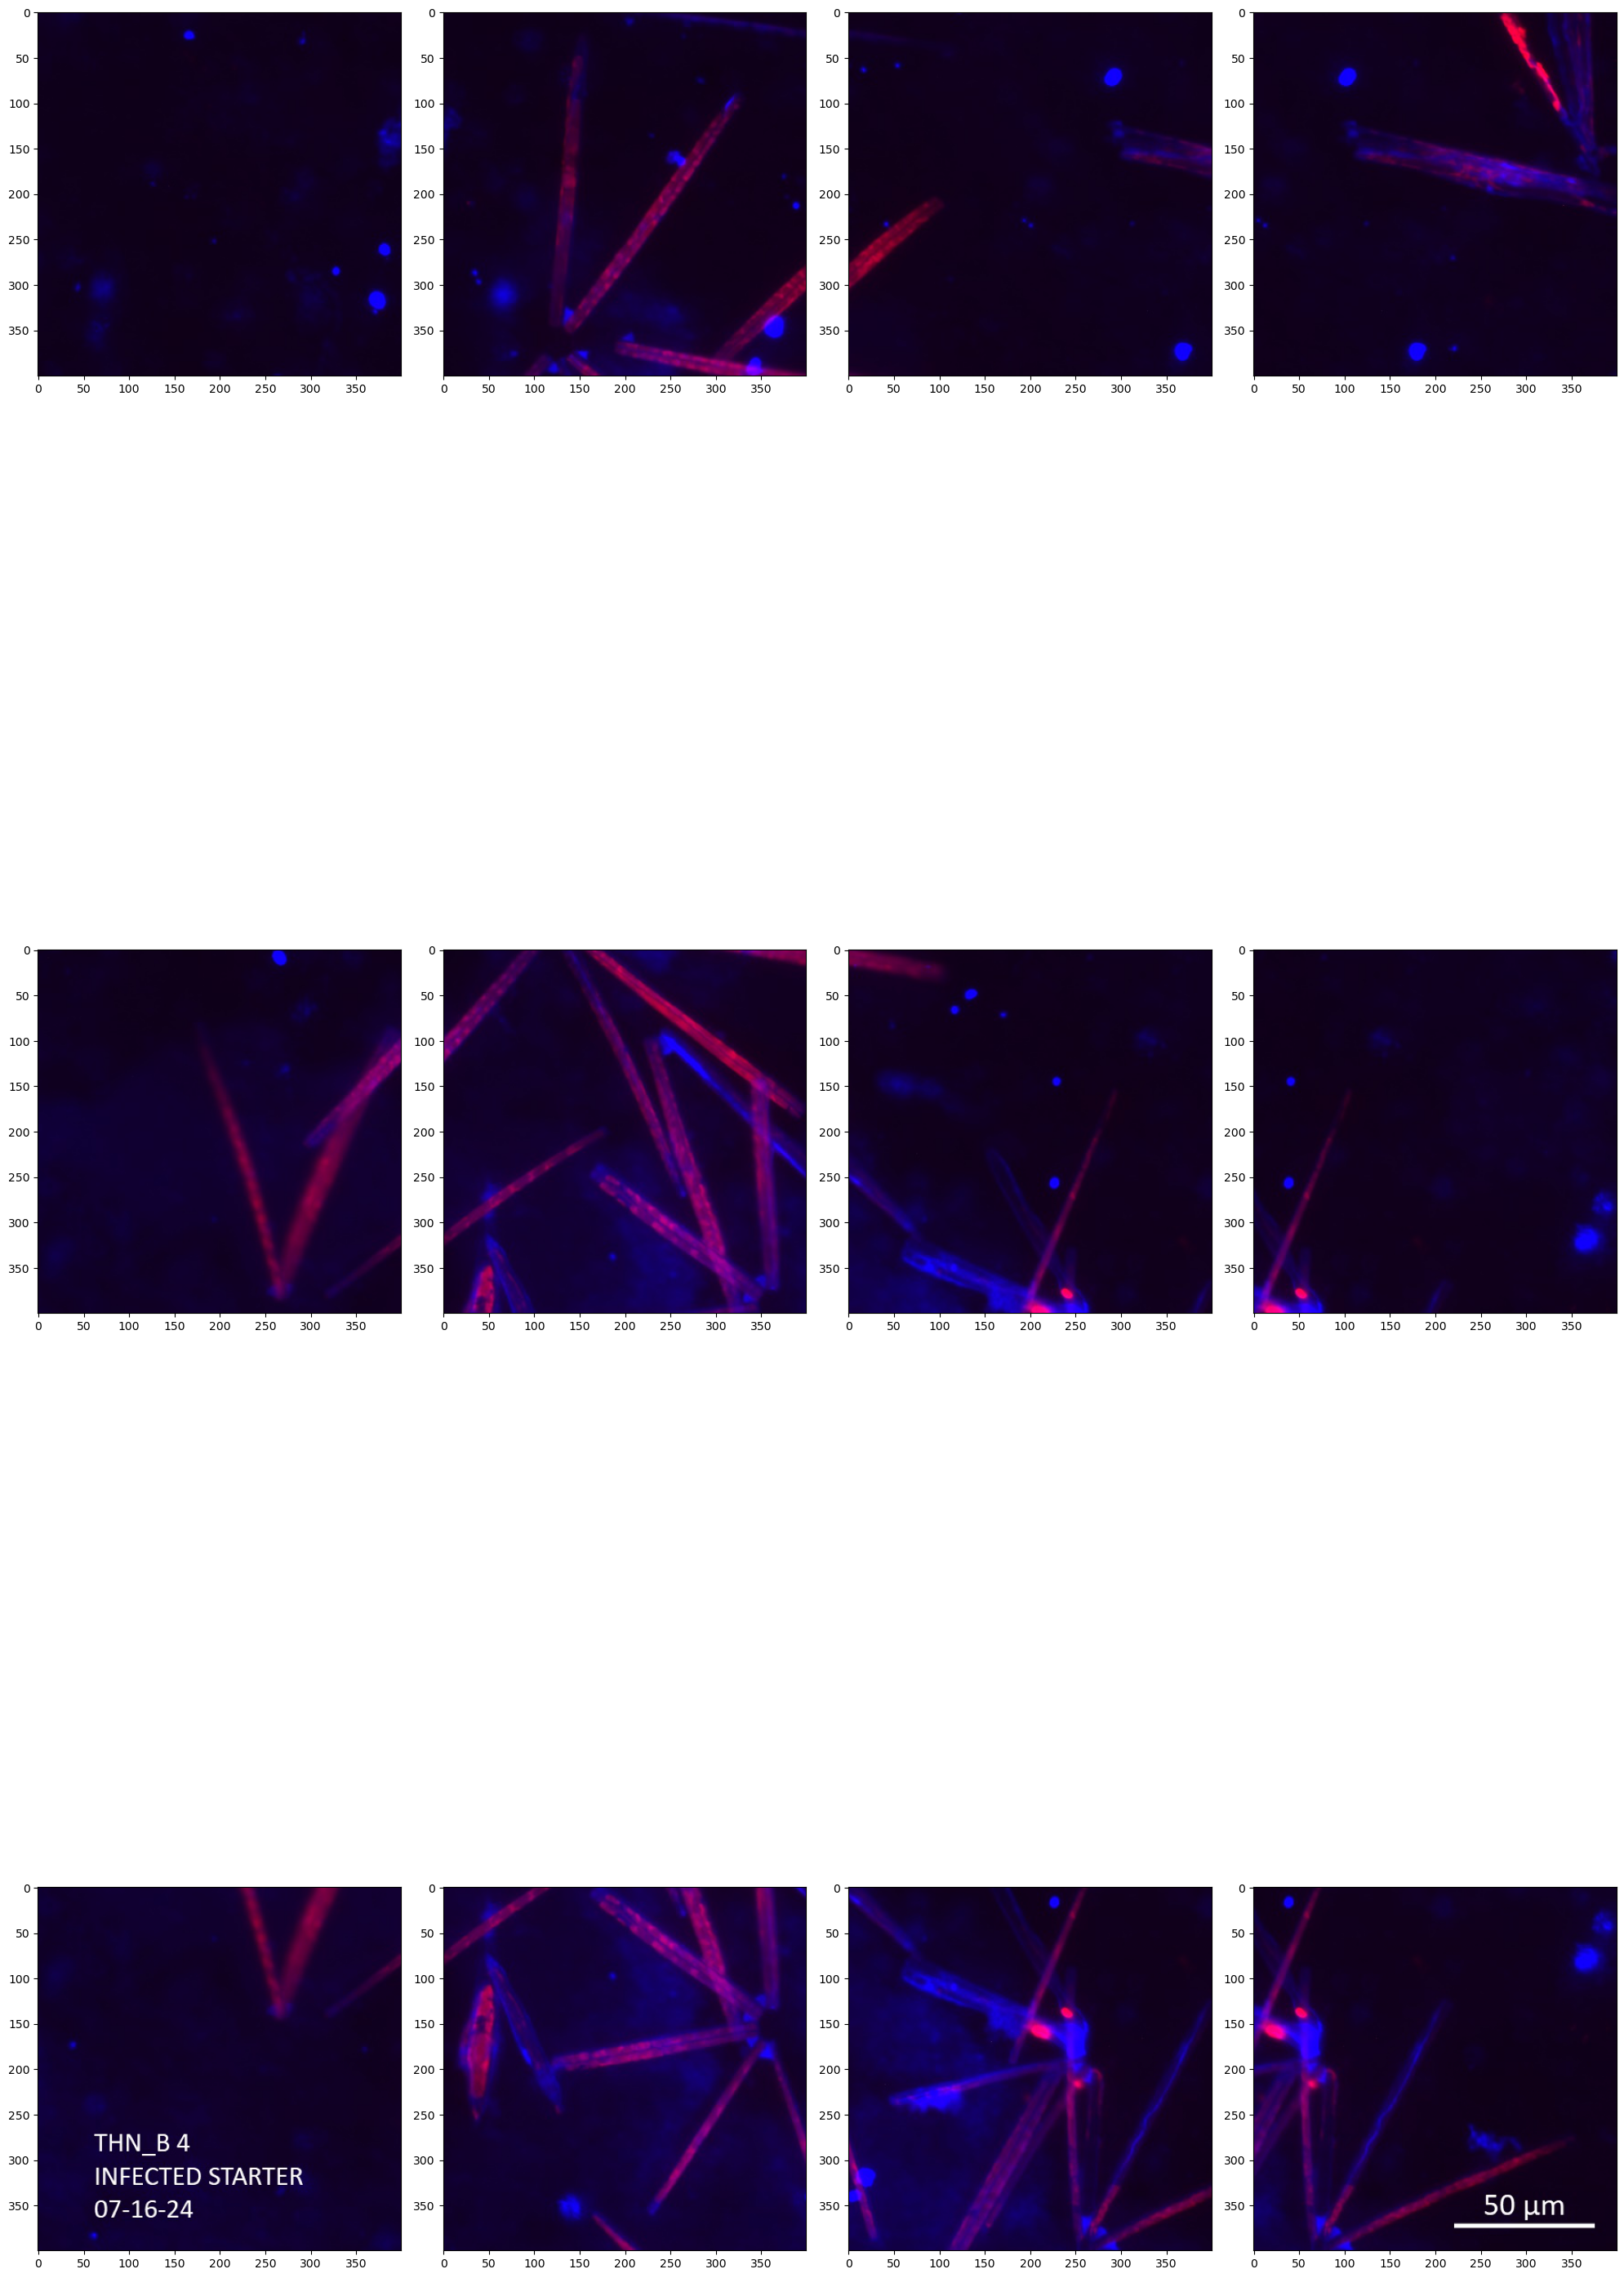

In [12]:
#make sure these are ordered correctly
fig, ax = plt.subplots(3,4, figsize=(20, 40))

for i in range(0,12):
    ax[i%3,int(i/3)].imshow(tiled_x_cell[-1][i])
fig.tight_layout()

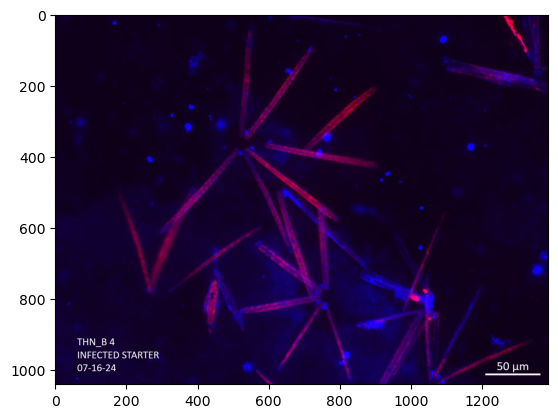

In [13]:
#for comparison, the original image
plt.imshow(X[-1])

In [14]:
#looks correct, moving on


In [15]:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [16]:
IMG_CHANNELS=3
inputs = Input((400,400, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',loss_weights=[1,1000])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

We must normalize our y data, which currently ranges from 0 to 255, to range from 0 to 1, as otherwise we will encounter issues in loss function calculation.

In [17]:
y_cell=y_cell/255

In [18]:
model.load_weights('models/cell_model.h5')


In [19]:
predictions=model.predict(np.array(tiled_x_cell[-1]))

1/1 [==============================] - 1s 752ms/step


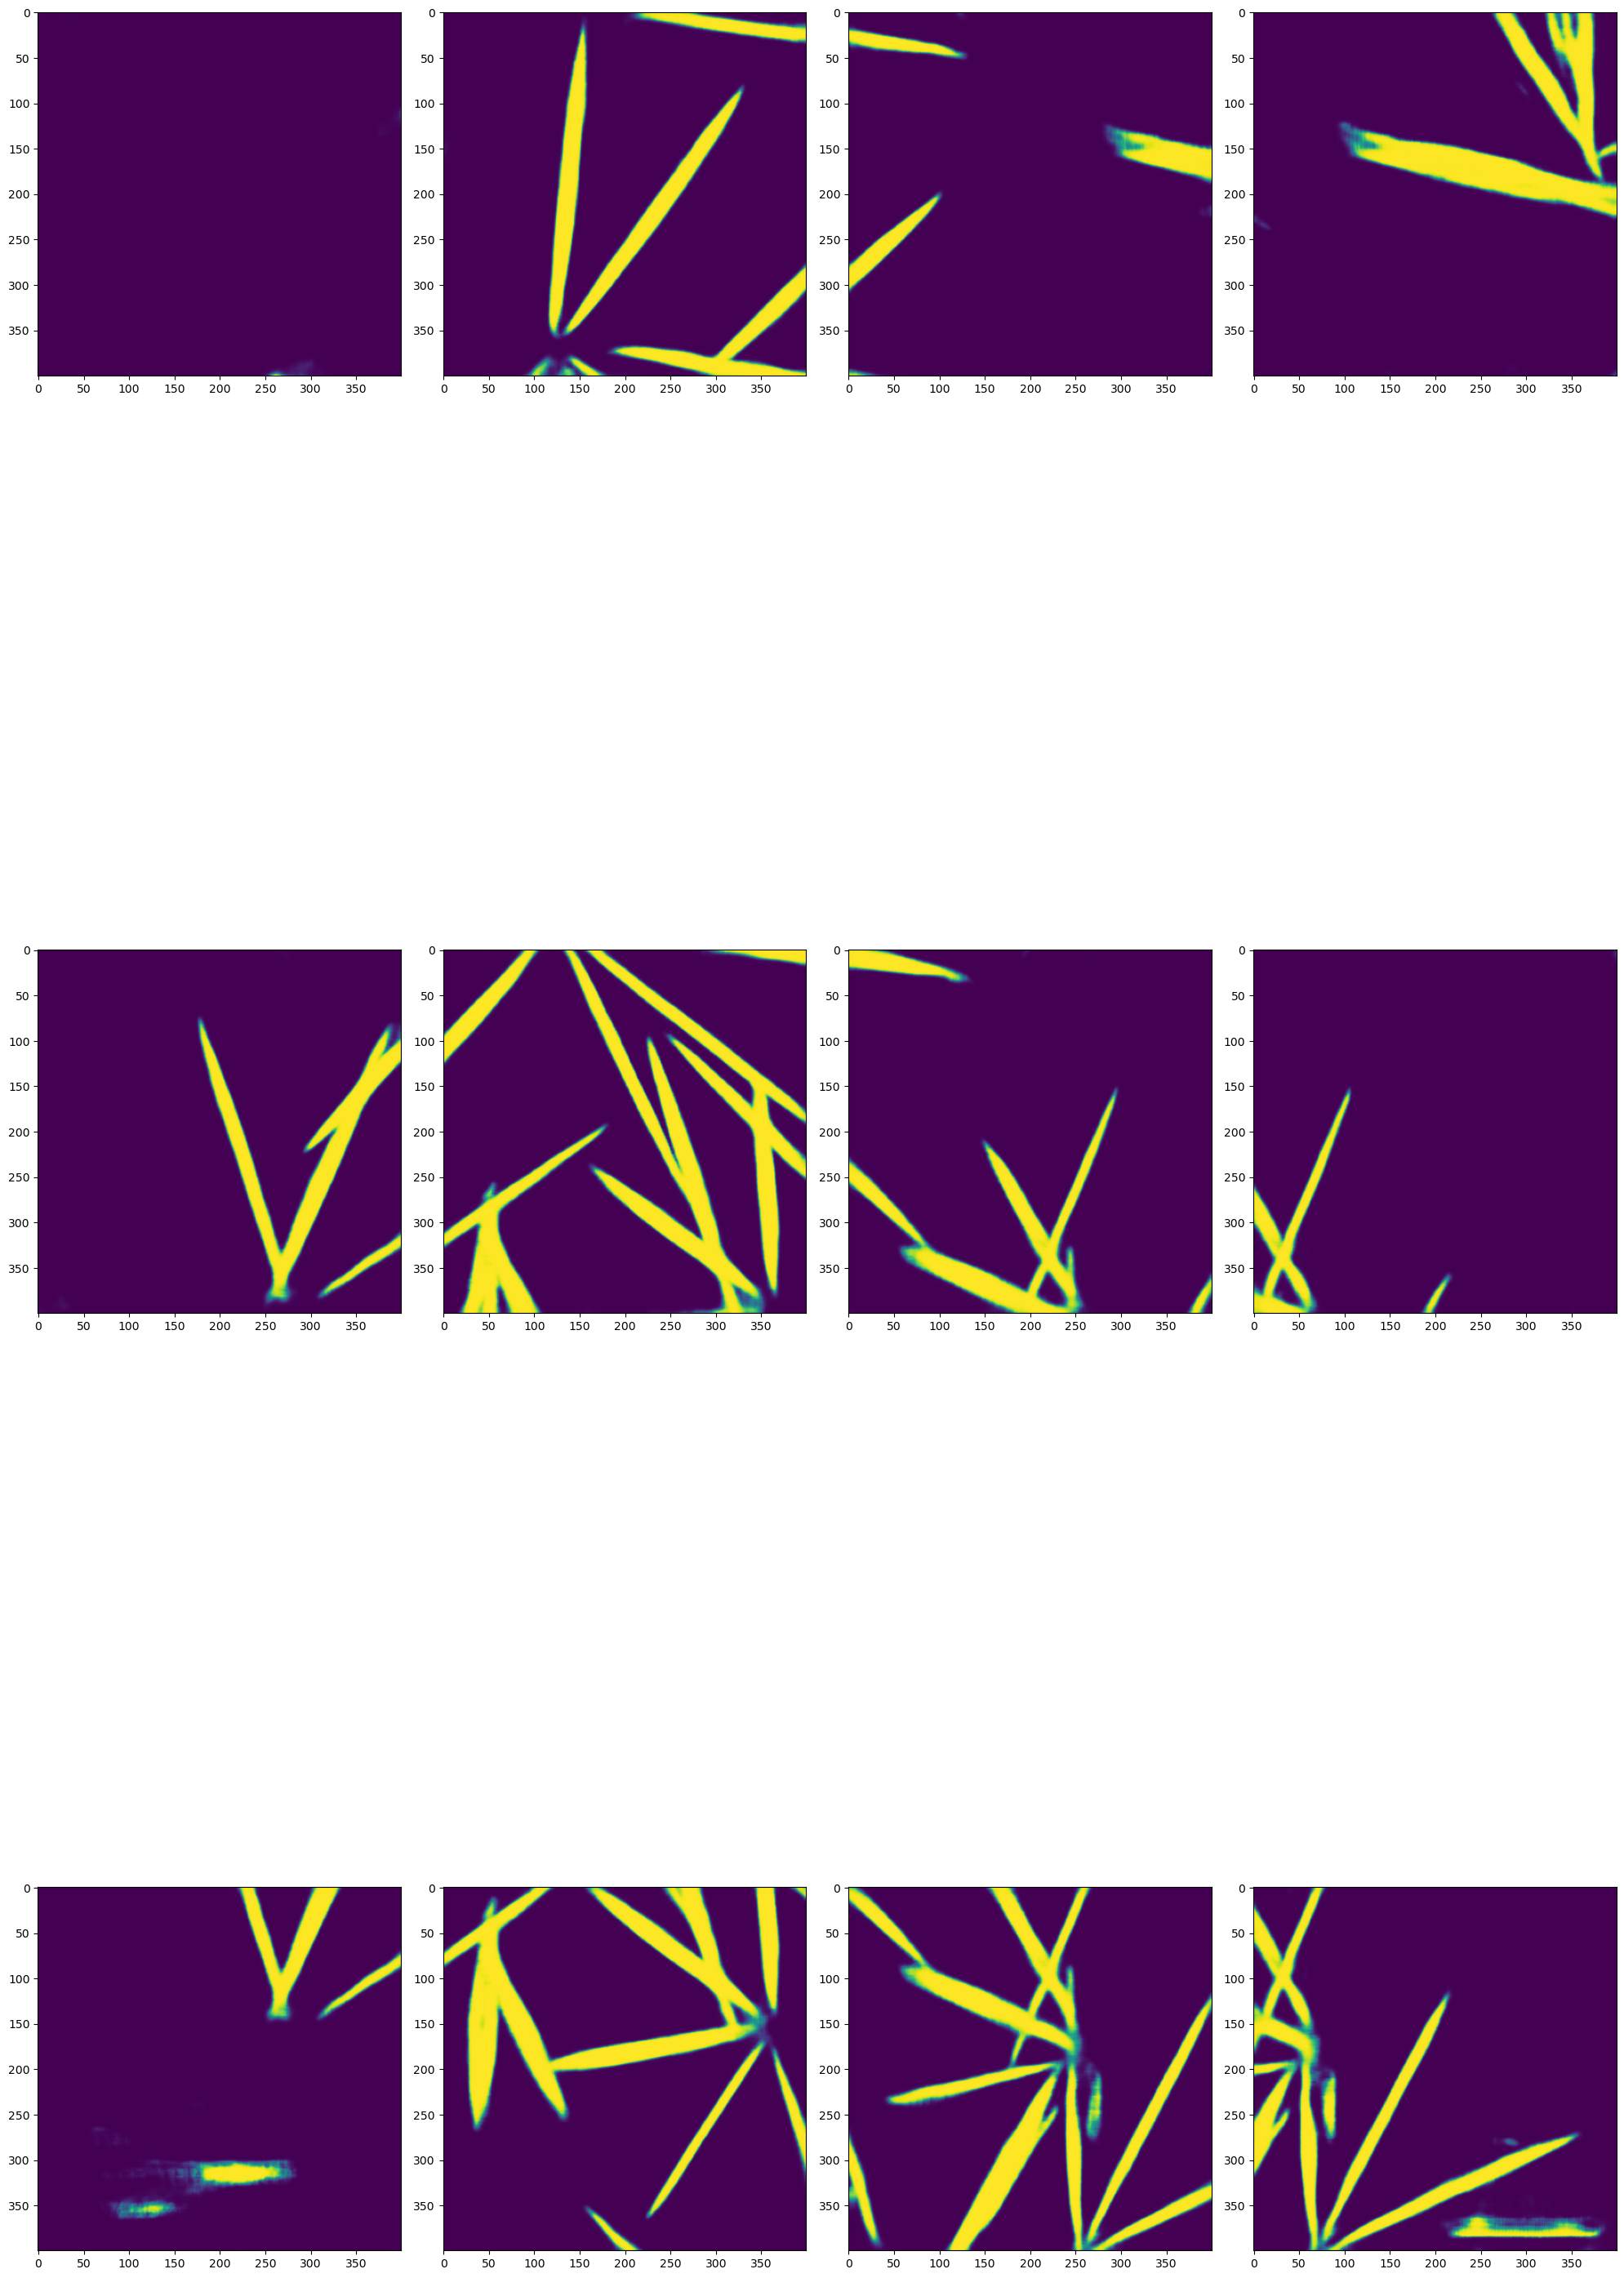

In [20]:
fig, ax = plt.subplots(3,4, figsize=(20, 40))

for i in range(0,12):
    ax[i%3,int(i/3)].imshow(predictions[i])
fig.tight_layout()

In [44]:
single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)

In [86]:
#get predictions back into a single np array per image
single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)
max_x,max_y=1040,1388
single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
for i in range(len(predictions)):
    if i%3*400+400<max_x and int(i/3)*400+400<max_y:
        '''for x_pos in range(0,400):
            for y_pos in range(0,400):
                single_prediction[int(i%3*400+x_pos), int(int(i/3)*400+y_pos),0]=predictions[1][x_pos,y_pos][0]'''
        single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=predictions[i]
    elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
        single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=predictions[i][:,400-(max_y-int(i/3)*400):]
    elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
        single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=predictions[i][400-(max_x-i%3*400):,:]
    else:
        print(i)
        print(predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:].shape)
        single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]


11
(240, 188, 1)


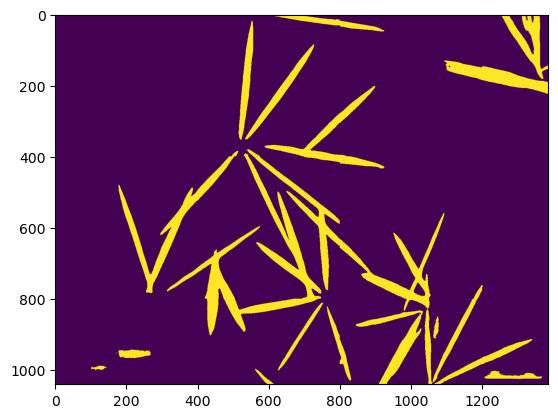

In [87]:
plt.imshow(single_prediction>0.5)

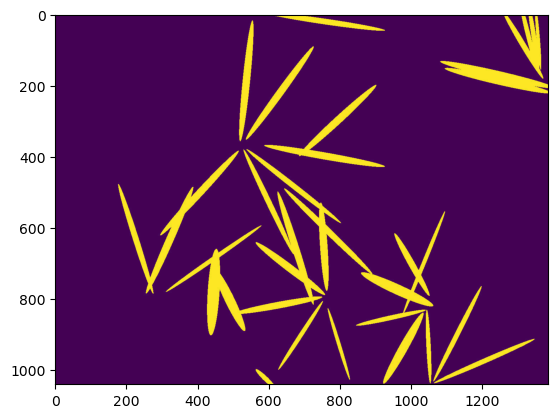

In [88]:
plt.imshow(y_cell[-1])

In [89]:

np.sum(y_cell[-1]==((single_prediction>0.5)[:,:,0]))/(1388*1040)

0.9428376468632232

In [90]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

In [94]:
DICE_COE(y_cell[-1],(single_prediction>0.5)[:,:,0])

0.9

In [102]:
joined_predictions=[]
for j in range(len(X)):
    predictions=model.predict(np.array(tiled_x_cell[j]))
    single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)
    max_x,max_y=1040,1388
    single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
    for i in range(len(predictions)):
        if i%3*400+400<max_x and int(i/3)*400+400<max_y:
            '''for x_pos in range(0,400):
                for y_pos in range(0,400):
                    single_prediction[int(i%3*400+x_pos), int(int(i/3)*400+y_pos),0]=predictions[1][x_pos,y_pos][0]'''
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=predictions[i]
        elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=predictions[i][:,400-(max_y-int(i/3)*400):]
        elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=predictions[i][400-(max_x-i%3*400):,:]
        else:
            single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]
    joined_predictions.append(single_prediction)

1/1 [==============================] - 0s 355ms/step


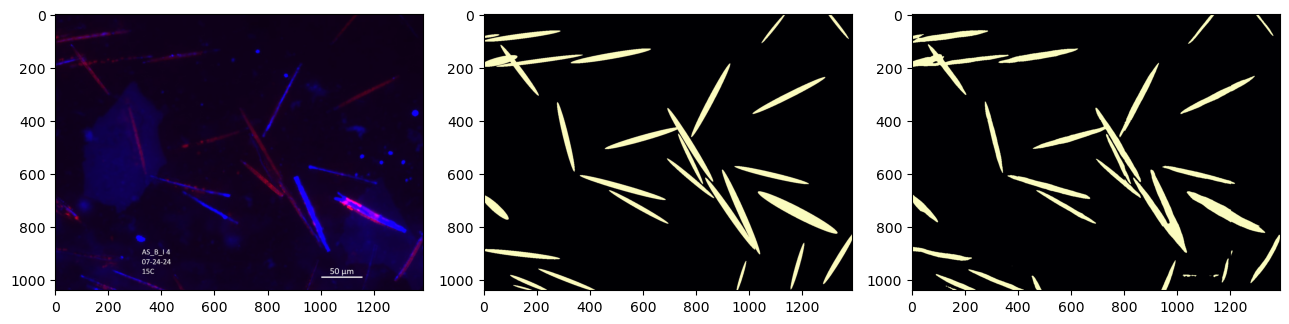

In [107]:
accuracies,
fig, ax = plt.subplots(24, 3, figsize=(20, 40)))
ax[0].imshow(X[i], cmap='magma')
ax[1].imshow(y_cell[i], cmap='magma')
ax[2].imshow(joined_predictions[i]>0.5, cmap='magma')
fig.tight_layout()

In [67]:
(single_prediction>0.9)[:,:,0].shape

(1040, 1388)

In [ ]:
predictions[1][x_pos,y_pos][0]

In [ ]:
i%3*400+x_pos

In [ ]:
print(np.max(single_prediction))

In [ ]:
single_prediction.shape

In [ ]:
int(i/3)*400+400

In [ ]:
single_prediction=np.zeros((1040,1388),dtype=np.uint8)

Now we can train the first model on the cell bodies.  I have allowed for 50 epochs (runs through the entire training data set) though in practice it will probably not need that many.  While training, we are interested in decreasing the model loss function.  The val_loss refers to loss calculated on the validation set (which is held out in training).  We have also enabled early stopping as neural networks, when allowed to run forever, tend to eventually stop learning meaningful patterns and begin memorizing data images, which results in a worsening of validation loss.  The early stopping functionality makes backups of the model after each epoch, then stops training and reverts to the previous best model as soon as the validation loss begins to worsen.

In [ ]:

# ===========================================================
# Train the model
# ===========================================================

filepath = "models/cell_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)


In [ ]:
model.load_weights('models/cell_model.h5')


In [ ]:
in_sample_prediction=model.predict(X_train)

In [ ]:
num=300
fig, ax = plt.subplots(1, 3, figsize=(13, 10))
ax[0].imshow(augmented_X_train[num], cmap='magma')
ax[1].imshow(augmented_y_train[num], cmap='magma')
ax[2].imshow(in_sample_prediction[num], cmap='magma')
fig.tight_layout()

In [ ]:
#show some in-sample predictions
predictions=model.predict(X_train[:10])
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(0,10):
    ax[i,0].imshow(X_train[i], cmap='magma')
    ax[i,1].imshow(y_train[i], cmap='magma')
    ax[i,2].imshow(predictions[i], cmap='magma')
    fig.tight_layout()

In [ ]:
predictions=model.predict(X_test)

In [ ]:
#show some out-of-sample predictions
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(0,10):
    ax[i,0].imshow(X_test[i], cmap='magma')
    ax[i,1].imshow(y_test[i], cmap='magma')
    ax[i,2].imshow(predictions[i], cmap='magma')
    fig.tight_layout()

Nice!